# Calculating anomalies and climatologies of (satellite) timeseries with pytesmo


The following example shows how you can use pytesmo to calculate anomalies or the climatology of a times eries. Here we use the test data that is provided within the Github repository, but it works the same with all pandas DataFrames or Series.

In [3]:
%matplotlib inline

from ascat.read_native.cdr import AscatGriddedNcTs
from pytesmo.time_series import anomaly
from pathlib import Path
import warnings
import matplotlib.pyplot as plt

The first step is to read in the ASCAT data at a single grid point and plot the resulting soil moisture time series:

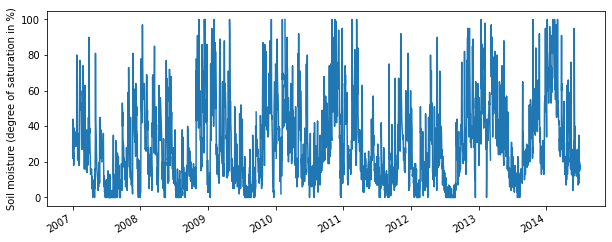

In [4]:
testdata_path = Path(".").resolve().parent.parent / "tests" / "test-data"
ascat_data_folder = testdata_path / "sat" / "ascat" / "netcdf" / "55R22"
ascat_grid_fname = testdata_path / "sat" / "ascat" / "netcdf" / "grid" / "TUW_WARP5_grid_info_2_1.nc"
static_layer_path = testdata_path / "sat" / "h_saf" / "static_layer"


#init the AscatSsmCdr reader with the paths
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # some warnings are expected and ignored
    
    ascat_reader = AscatGriddedNcTs(
        ascat_data_folder,
        "TUW_METOP_ASCAT_WARP55R22_{:04d}",
        grid_filename=ascat_grid_fname,
        static_layer_path=static_layer_path
    )
    
ascat_ts = ascat_reader.read(11.82935429,45.4731369)
ascat_ts["sm"].plot(figsize=(10, 4))
plt.ylabel("Soil moisture (degree of saturation in %)");

This timeseries shows a seasonal pattern of high soil moisture in winter and low soil moisture in summer, so we might be interested in the climatology (long-term mean seasonal pattern) or in anomalies from the climatology or from the current seasonality (calculated via a moving window of 35 days).

This can be done with the `calc_climatology` and `calc_anomaly` functions in `pytesmo.time_series.anomaly`.

Let's first have a look at the climatology:

In [5]:
climatology = anomaly.calc_climatology(ascat_ts["sm"])
climatology

1      40.725439
2      41.293034
3      41.988083
4      42.341582
5      42.948949
         ...    
362    39.143497
363    39.534965
364    39.734723
365    40.090585
366    40.479103
Length: 366, dtype: float64

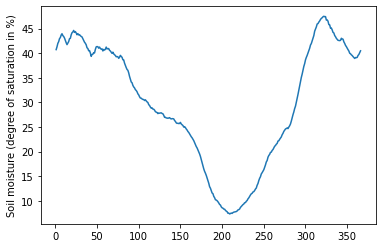

In [6]:
climatology.plot()
plt.ylabel("Soil moisture (degree of saturation in %)");

The returned climatology is a pandas Series with the day of year as index (ranging from 1 to 366). Here we can see more clearly the pattern we spotted above in the full timeseries.

We can use this climatology to calculate the anomalies from it, e.g. soil moisture signal - climatology:

Calculate anomaly based on moving +- 17 day window:

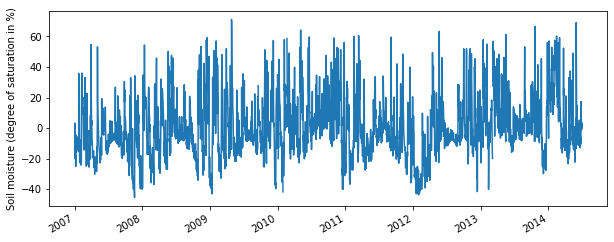

In [7]:
anomaly_clim = anomaly.calc_anomaly(ascat_ts["sm"], climatology=climatology)
anomaly_clim.plot(figsize=(10, 4))
plt.ylabel("Soil moisture (degree of saturation in %)");

We can also base our anomaly calculation on a running mean. This way we can get the short-term anomalies separated from a smoothed signal showing the seasonal contributions. Here we use a window of 35 days, e.g +- 17 days in each direction:

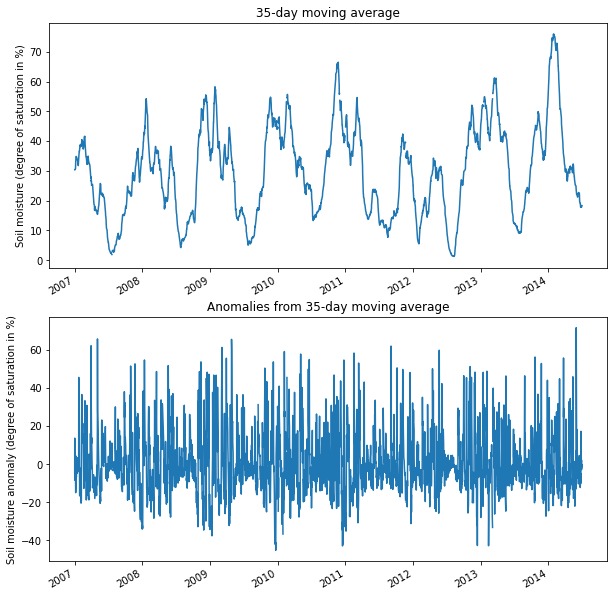

In [8]:
anomaly_seasonal = anomaly.calc_anomaly(ascat_ts["sm"], window_size=35)
seasonal = ascat_ts["sm"] - anomaly_seasonal

fig, axes = plt.subplots(nrows=2, figsize=(10, 11))
seasonal.plot(ax=axes[0])
axes[0].set_ylabel("Soil moisture (degree of saturation in %)")
axes[0].set_title("35-day moving average")
anomaly_seasonal.plot(ax=axes[1])
axes[1].set_ylabel("Soil moisture anomaly (degree of saturation in %)")
axes[1].set_title("Anomalies from 35-day moving average");